##Import Library

In [109]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import *
from pyspark.ml.feature import *
from pyspark.ml import *
from pyspark.ml.classification import *
from pyspark.ml.evaluation import *
from pyspark.ml.tuning import *
from sklearn.metrics import *
import matplotlib.pyplot as plt

##Eksplorasi Dataset

In [110]:
# Membuat SparkSession
spark = SparkSession.builder.appName("HappinessClassification").getOrCreate()

# Memuat Dataset
file_path = "/content/2019.csv"
data = spark.read.csv(file_path, header=True, inferSchema=True)

# Eksplorasi Dataset
data.show(5)
jumlah_negara = data.select("Country or region").distinct().count() # Jumlah Negara
print(f"Jumlah Negara: {jumlah_negara}")
data.select(avg("Score")).show() # Rata-Rata Skor Kebahagiaan

+------------+-----------------+-----+--------------+--------------+-----------------------+----------------------------+----------+-------------------------+
|Overall rank|Country or region|Score|GDP per capita|Social support|Healthy life expectancy|Freedom to make life choices|Generosity|Perceptions of corruption|
+------------+-----------------+-----+--------------+--------------+-----------------------+----------------------------+----------+-------------------------+
|           1|          Finland|7.769|          1.34|         1.587|                  0.986|                       0.596|     0.153|                    0.393|
|           2|          Denmark|  7.6|         1.383|         1.573|                  0.996|                       0.592|     0.252|                     0.41|
|           3|           Norway|7.554|         1.488|         1.582|                  1.028|                       0.603|     0.271|                    0.341|
|           4|          Iceland|7.494|        

## Kategori Tingkat Kebahagiaan

In [111]:
# Menambahkan kolom Hapiness_Level
data = data.withColumn(
    "Happiness_Level",
    when(data["Score"] < 4, "Low")
    .when((data["Score"] >= 4) & (data["Score"] < 6), "Medium")
    .otherwise("High")
)


# Verifikasi distribusi kategori
data.groupBy("Happiness_Level").count().show()

+---------------+-----+
|Happiness_Level|count|
+---------------+-----+
|           High|   52|
|            Low|   16|
|         Medium|   88|
+---------------+-----+



## Pra-Pemrosesan Data

In [112]:
# Konversi Happiness_Level menjadi numerik
indexer = StringIndexer(inputCol="Happiness_Level", outputCol="Happiness_Level_Index")
indexer_model = indexer.fit(data)  # Simpan model setelah fit
data = indexer_model.transform(data)

# Ambil label dari indexer_model
labels = indexer_model.labels

# Gabungkan semua fitur numerik
feature_cols = [
    "GDP per capita",
    "Social support",
    "Healthy life expectancy",
    "Freedom to make life choices",
    "Generosity",
    "Perceptions of corruption",
]
assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")
data = assembler.transform(data)

# Standarisasi data
scaler = StandardScaler(inputCol="features", outputCol="scaled_features")
data = scaler.fit(data).transform(data)

## Model Machine Learning

## Random Forest

In [113]:
# Random Forest Classifier
rf = RandomForestClassifier(featuresCol="scaled_features", labelCol="Happiness_Level_Index")

# Pipeline Random Forest
rf_pipeline = Pipeline(stages=[rf])
rf_model = rf_pipeline.fit(data)

# Evaluasi model
evaluator = MulticlassClassificationEvaluator(labelCol="Happiness_Level_Index", metricName="accuracy")

rf_accuracy = evaluator.evaluate(rf_model.transform(data))

print(f"Random Forest Accuracy: {rf_accuracy}")

Random Forest Accuracy: 0.9166666666666666


## Optimasi Hyperparameter

## Random Forest

In [114]:
# Grid search untuk Random Forest
paramGrid = ParamGridBuilder()\
    .addGrid(rf.numTrees, [10, 20, 50])\
    .addGrid(rf.maxDepth, [5, 10, 15])\
    .build()

cv = CrossValidator(
    estimator=rf_pipeline,
    estimatorParamMaps=paramGrid,
    evaluator=evaluator,
    numFolds=5,
)

cv_model = cv.fit(data)
best_model = cv_model.bestModel
accuracy = evaluator.evaluate(best_model.transform(data))

print(f"Optimized Random Forest Accuracy: {accuracy}")

Optimized Random Forest Accuracy: 0.9935897435897436


## Interpretasi Hasil

## Random Forest (Best Model Accuracy)

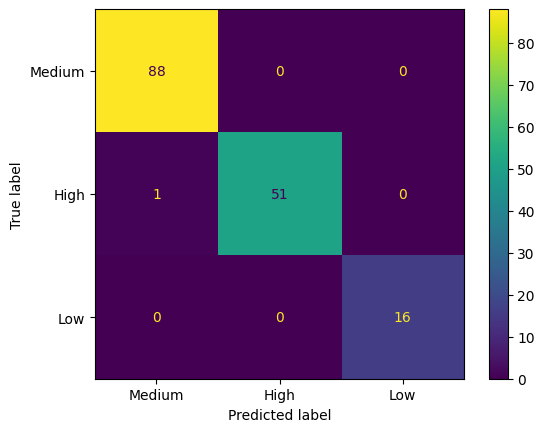

In [115]:
# Model prediksi
predictions = best_model.transform(data)
y_true = predictions.select("Happiness_Level_Index").toPandas()
y_pred = predictions.select("prediction").toPandas()

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot()

plt.show()